In [200]:
import pandas as pd
import geopandas as gpd

# Load the population density CSV
pop_density_file = './data/pop_density.csv'  # Update with your file path
pop_density = pd.read_csv(pop_density_file)

# Rename the columns
pop_density.rename(columns={"Lower Tier Local Authorities": "Region", "Observation": "Density"}, inplace=True)
print(pop_density.head()) 

  Lower Tier Local Authorities Code                Region  Density
0                         E06000001            Hartlepool    985.5
1                         E06000002         Middlesbrough   2671.2
2                         E06000003  Redcar and Cleveland    557.1
3                         E06000004      Stockton-on-Tees    959.3
4                         E06000005            Darlington    545.9


In [201]:
import os

# Merge the shp files in ./data/LB_shp
# Define the folder containing your shapefiles
folder_path = "./data/LB_shp"  # Adjust this path to where your shapefiles are stored

# Find all .shp files in the folder
shapefiles = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".shp")]

# Load and combine all shapefiles into one GeoDataFrame
combined_geo = gpd.GeoDataFrame(pd.concat([gpd.read_file(shp) for shp in shapefiles], ignore_index=True))

# Save the combined shapefile
output_path = "./data/london_combined.shp"
combined_geo.to_file(output_path, driver="ESRI Shapefile")

print(f"Combined shapefile saved at: {output_path}")

Combined shapefile saved at: ./data/london_combined.shp


In [202]:
# Check the columns for consistency
print(combined_geo.head())
print(combined_geo.columns)  
print(combined_geo.info)

    lsoa21cd        lsoa21nm   msoa21cd       msoa21nm    lad22cd    lad22nm  \
0  E01003912  Southwark 019A  E02000825  Southwark 019  E09000028  Southwark   
1  E01003923  Southwark 017A  E02000823  Southwark 017  E09000028  Southwark   
2  E01003924  Southwark 021E  E02000827  Southwark 021  E09000028  Southwark   
3  E01003925  Southwark 020E  E02000826  Southwark 020  E09000028  Southwark   
4  E01003926  Southwark 021F  E02000827  Southwark 021  E09000028  Southwark   

                                            geometry  
0  POLYGON ((533471.653 177037.166, 533477.64 177...  
1  POLYGON ((532355 177476, 532345 177471, 532343...  
2  POLYGON ((532427.225 177454.5, 532428.336 1774...  
3  POLYGON ((532944.189 177229.842, 532936.114 17...  
4  POLYGON ((532023.078 177417.796, 532028.968 17...  
Index(['lsoa21cd', 'lsoa21nm', 'msoa21cd', 'msoa21nm', 'lad22cd', 'lad22nm',
       'geometry'],
      dtype='object')
<bound method DataFrame.info of        lsoa21cd        lsoa21nm   msoa

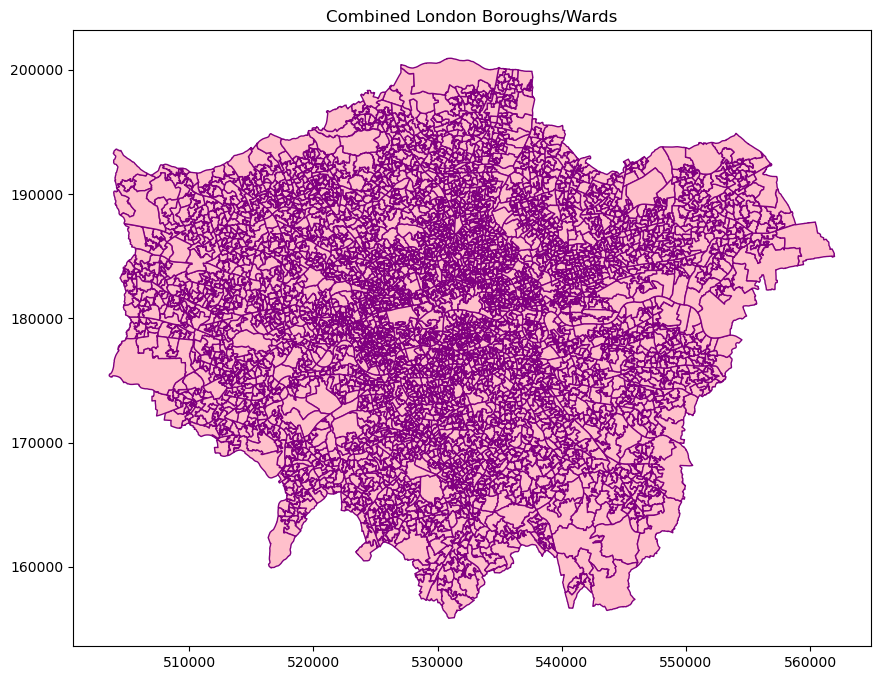

In [203]:
import matplotlib.pyplot as plt

# Plot the combined GeoDataFrame
combined_geo.plot(figsize=(12, 8), color="pink", edgecolor="purple")
plt.title("Combined London Boroughs/Wards")
plt.show()

In [204]:
# Aggregate Wards into Boroughs

# Example for cleaning the Borough column
combined_geo['lsoa21nm'] = combined_geo['lsoa21nm'].str.split(" ").str[0]  # Keep only the first word

# Check the cleaned data
print(combined_geo["lsoa21nm"].unique())  # This should now show just the borough names

['Southwark' 'Harrow' 'Richmond' 'Hounslow' 'Lambeth' 'Newham' 'Enfield'
 'Barking' 'Barnet' 'Islington' 'Ealing' 'Bexley' 'Sutton' 'Kensington'
 'Hillingdon' 'Bromley' 'Kingston' 'Wandsworth' 'City' 'Redbridge'
 'Waltham' 'Croydon' 'Brent' 'Hammersmith' 'Hackney' 'Greenwich'
 'Lewisham' 'Merton' 'Tower' 'Camden' 'Westminster' 'Haringey' 'Havering']


In [205]:
# Dissolve Geometry by Borough
# After cleaning the borough names, you can aggregate the geometries using the dissolve() function.

# Dissolve by the cleaned Borough column
boroughs_geo = combined_geo.dissolve(by="lsoa21nm", as_index=False)

# Keep only the Borough name and geometry columns
boroughs_geo = boroughs_geo[["lsoa21nm", "geometry"]]

# Check the resulting GeoDataFrame
print(boroughs_geo.head())
print(boroughs_geo.info)

  lsoa21nm                                           geometry
0  Barking  POLYGON ((545645.563 181700.859, 545607 181718...
1   Barnet  POLYGON ((521273.406 187493.516, 521271.265 18...
2   Bexley  POLYGON ((546721.195 170430.371, 546720.484 17...
3    Brent  POLYGON ((518456.781 183160.781, 518434.662 18...
4  Bromley  POLYGON ((537411.335 166327.14, 537407.704 166...
<bound method DataFrame.info of        lsoa21nm                                           geometry
0       Barking  POLYGON ((545645.563 181700.859, 545607 181718...
1        Barnet  POLYGON ((521273.406 187493.516, 521271.265 18...
2        Bexley  POLYGON ((546721.195 170430.371, 546720.484 17...
3         Brent  POLYGON ((518456.781 183160.781, 518434.662 18...
4       Bromley  POLYGON ((537411.335 166327.14, 537407.704 166...
5        Camden  POLYGON ((526428.573 183893.664, 526426.725 18...
6          City  POLYGON ((533646.637 181373.026, 533659.438 18...
7       Croydon  POLYGON ((531947.813 156595, 531945.62 1565

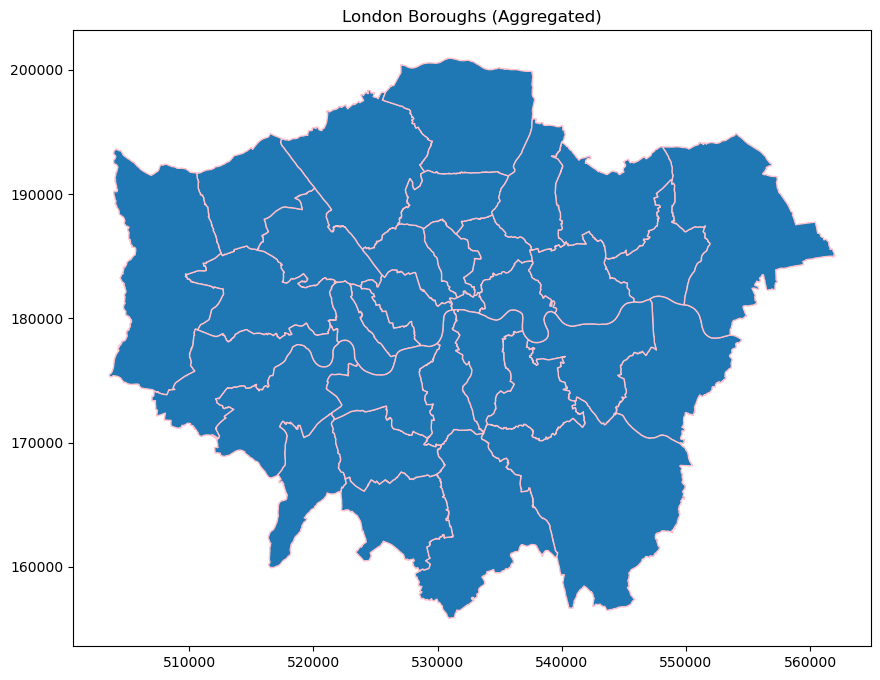

In [206]:
boroughs_geo.plot(figsize=(12, 8), edgecolor="pink")
plt.title("London Boroughs (Aggregated)")
plt.show()


In [207]:
# Load the population density data
# pop_density = pd.read_csv("./data/pop_density.csv")

# Ensure column names in both datasets match (adjust if needed)
print(boroughs_geo.columns)  # Check the spatial data columns
print(pop_density.columns)   # Check the population density data columns

# Merge population density data
boroughs_geo = boroughs_geo.merge(pop_density, left_on="lsoa21nm", right_on="Region", how="left")

# Check for missing data
print(boroughs_geo.isnull().sum())

Index(['lsoa21nm', 'geometry'], dtype='object')
Index(['Lower Tier Local Authorities Code', 'Region', 'Density'], dtype='object')
lsoa21nm                             0
geometry                             0
Lower Tier Local Authorities Code    8
Region                               8
Density                              8
dtype: int64


In [208]:
# Identify missing rows

# Check rows with missing values
missing_rows = boroughs_geo[boroughs_geo["Density"].isnull()]
print(missing_rows[["lsoa21nm", "geometry"]])  # Display missing rows

# Check unique borough names in both datasets
print("GeoDataFrame boroughs:", boroughs_geo["lsoa21nm"].unique())
print("Population dataset regions:", pop_density["Region"].unique())

       lsoa21nm                                           geometry
0       Barking  POLYGON ((545645.563 181700.859, 545607 181718...
6          City  POLYGON ((533646.637 181373.026, 533659.438 18...
12  Hammersmith  POLYGON ((522199.63 178141.098, 522188.531 178...
19   Kensington  POLYGON ((524531.838 178988.852, 524515.336 17...
20     Kingston  POLYGON ((518563.434 162424.99, 518558.781 162...
26     Richmond  POLYGON ((513592.846 169201.809, 513577.375 16...
29        Tower  POLYGON ((535184.037 180072.22, 535183.762 180...
30      Waltham  POLYGON ((536642.063 186557.922, 536639.812 18...
GeoDataFrame boroughs: ['Barking' 'Barnet' 'Bexley' 'Brent' 'Bromley' 'Camden' 'City' 'Croydon'
 'Ealing' 'Enfield' 'Greenwich' 'Hackney' 'Hammersmith' 'Haringey'
 'Harrow' 'Havering' 'Hillingdon' 'Hounslow' 'Islington' 'Kensington'
 'Kingston' 'Lambeth' 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond'
 'Southwark' 'Sutton' 'Tower' 'Waltham' 'Wandsworth' 'Westminster']
Population dataset reg

In [209]:
# Create a dictionary to map mismatched borough names
name_corrections = {
    "Hammersmith": "Hammersmith and Fulham",
    "Barking": "Barking and Dagenham",
    "Kensington":"Kensington and Chelsea",
    "Kingston":"Kingston upon Thames",
    "City":"City Of London",
    "Tower":"Tower Hamlets",
    "Waltham": "Waltham Forest"
}

# Apply the corrections
boroughs_geo["lsoa21nm"] = boroughs_geo["lsoa21nm"].replace(name_corrections)

# Ensure column names in both datasets match (adjust if needed)
print(boroughs_geo.columns)  # Check the spatial data columns
print(pop_density.columns)   # Check the population density data columns

# # Merge population density data
# boroughs_geo = boroughs_geo.merge(pop_density, left_on='lsoa21nm', right_on='Region', how="left")

# # Check for missing data
# print(boroughs_geo.isnull().sum())
# # Re-check if any misssing rows
missing_rows = boroughs_geo[boroughs_geo['Density'].isnull()]
missing_rows

Index(['lsoa21nm', 'geometry', 'Lower Tier Local Authorities Code', 'Region',
       'Density'],
      dtype='object')
Index(['Lower Tier Local Authorities Code', 'Region', 'Density'], dtype='object')


,lsoa21nm,geometry,Lower Tier Local Authorities Code,Region,Density
0,Barking and Dagenham,"POLYGON ((545645.563 181700.859, 545607 181718...",NaN,NaN,NaN
6,City Of London,"POLYGON ((533646.637 181373.026, 533659.438 18...",NaN,NaN,NaN
12,Hammersmith and Fulham,"POLYGON ((522199.63 178141.098, 522188.531 178...",NaN,NaN,NaN
19,Kensington and Chelsea,"POLYGON ((524531.838 178988.852, 524515.336 17...",NaN,NaN,NaN
20,Kingston upon Thames,"POLYGON ((518563.434 162424.99, 518558.781 162...",NaN,NaN,NaN
26,Richmond,"POLYGON ((513592.846 169201.809, 513577.375 16...",NaN,NaN,NaN
29,Tower Hamlets,"POLYGON ((535184.037 180072.22, 535183.762 180...",NaN,NaN,NaN
30,Waltham Forest,"POLYGON ((536642.063 186557.922, 536639.812 18...",NaN,NaN,NaN


In [210]:
 # Fill Missing Values manually
# Barking-6065.8, City of London- 2975, Hammersmith and Fulham - 11161.1, 
# Kensington and Chelsea - 11816.5, Kingston upon Thames - 4512.1, Tower Hamlets - 15702.9, Waltham Forest - 7173.3

boroughs_geo.at[0, 'Density'] = 6065.8
boroughs_geo.at[6, 'Density'] = 2975
boroughs_geo.at[12, 'Density'] = 11161.1
boroughs_geo.at[19, 'Density'] = 11816.5
boroughs_geo.at[20, 'Density'] = 4512.1
boroughs_geo.at[29, 'Density'] = 15702.9
boroughs_geo.at[30, 'Density'] = 7173.3

print(boroughs_geo.isnull().sum())

# # # Re-check if any misssing rows
missing_rows = boroughs_geo[boroughs_geo['Density'].isnull()]
missing_rows

lsoa21nm                             0
geometry                             0
Lower Tier Local Authorities Code    8
Region                               8
Density                              1
dtype: int64


,lsoa21nm,geometry,Lower Tier Local Authorities Code,Region,Density
26,Richmond,"POLYGON ((513592.846 169201.809, 513577.375 16...",NaN,NaN,NaN


In [211]:
# Drop rows with missing population density
boroughs_geo = boroughs_geo.dropna(subset=["Density"])
print(boroughs_geo.isnull().sum())


lsoa21nm                             0
geometry                             0
Lower Tier Local Authorities Code    7
Region                               7
Density                              0
dtype: int64


In [212]:
missing_rows = boroughs_geo[boroughs_geo['Region'].isnull()]
missing_rows

,lsoa21nm,geometry,Lower Tier Local Authorities Code,Region,Density
0,Barking and Dagenham,"POLYGON ((545645.563 181700.859, 545607 181718...",NaN,NaN,6065.8
6,City Of London,"POLYGON ((533646.637 181373.026, 533659.438 18...",NaN,NaN,2975.0
12,Hammersmith and Fulham,"POLYGON ((522199.63 178141.098, 522188.531 178...",NaN,NaN,11161.1
19,Kensington and Chelsea,"POLYGON ((524531.838 178988.852, 524515.336 17...",NaN,NaN,11816.5
20,Kingston upon Thames,"POLYGON ((518563.434 162424.99, 518558.781 162...",NaN,NaN,4512.1
29,Tower Hamlets,"POLYGON ((535184.037 180072.22, 535183.762 180...",NaN,NaN,15702.9
30,Waltham Forest,"POLYGON ((536642.063 186557.922, 536639.812 18...",NaN,NaN,7173.3


In [213]:
boroughs_geo.at[0, 'Region'] = 'Barking and Dagenham'
boroughs_geo.at[6, 'Region'] = 'City Of London'
boroughs_geo.at[12, 'Region'] = 'Hammersmith and Fulham'
boroughs_geo.at[19, 'Region'] = 'Kensington and Chelsea'
boroughs_geo.at[20, 'Region'] = 'Kingston upon Thames'
boroughs_geo.at[29, 'Region'] = 'Tower Hamlets'
boroughs_geo.at[30, 'Region'] = 'Waltham Forest'

missing_rows = boroughs_geo[boroughs_geo['Region'].isnull()]
missing_rows

,lsoa21nm,geometry,Lower Tier Local Authorities Code,Region,Density


In [214]:
print(boroughs_geo.isnull().sum())  # Ensure no missing data

lsoa21nm                             0
geometry                             0
Lower Tier Local Authorities Code    7
Region                               0
Density                              0
dtype: int64


In [215]:
boroughs_geo = boroughs_geo.drop('Lower Tier Local Authorities Code', axis=1)

# Ensure no missing data
print(boroughs_geo.isnull().sum()) 

lsoa21nm    0
geometry    0
Region      0
Density     0
dtype: int64


In [198]:
boroughs_geo.info
boroughs_geo.to_csv("boroughs_geo_merged.csv")